# Arboles de decision

En esta clase entrenaremos y exploraremos arboles de decision.

In [1]:
from functools import lru_cache

In [2]:
import dtreeviz.trees as dtreeviz
import graphviz
import ipywidgets as widgets
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG, display
from ipywidgets import Button, IntSlider, interactive
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder

In [3]:
sns.set()

# Carga de datos

Vamos a usar un dataset de [valor de seguros](https://www.kaggle.com/mirichoi0218/insurance), cargandolo desde [github](https://github.com/stedy/Machine-Learning-with-R-datasets). Nuestra variable objetivo será la columna `smoker` que indica si es fumador o no.

In [4]:
@lru_cache()
def get_data():
    """Obtener el dataset.

    Devuelve
    --------
        pd.DataFrame: El dataset descargado desde github.
    """
    return pd.read_csv(
        'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv'
    )


dataset = get_data()

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
dataset.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

# Breve análisis exploratorio

In [7]:
report = ProfileReport(
    dataset, title='Dataset de seguros', explorative=True, lazy=False
)

In [8]:
report.to_widgets()
# -

Podemos ver que la variable objetivo está bastante desbalanceada

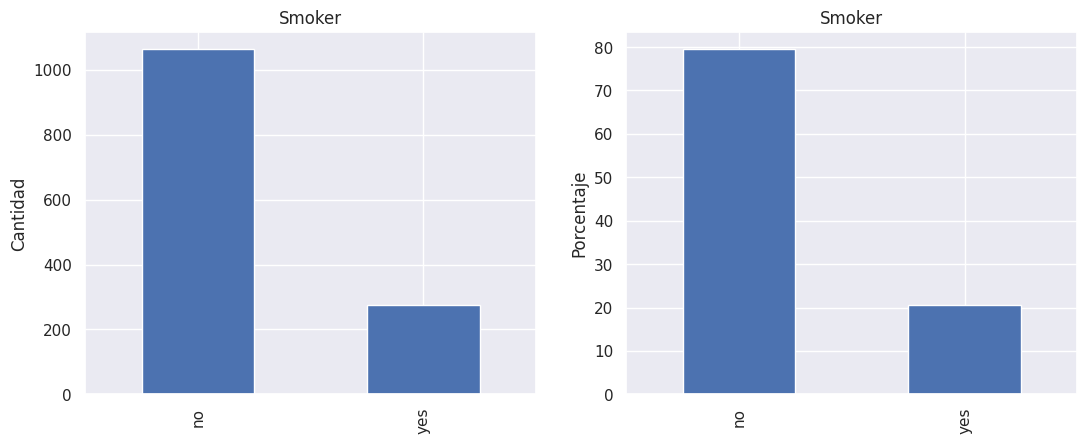

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

dataset.smoker.value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title("Smoker")
axes[0].set_ylabel("Cantidad")

dataset.smoker.value_counts().div(dataset.pipe(len)).mul(100).plot(
    kind='bar', ax=axes[1]
)
axes[1].set_title("Smoker")
axes[1].set_ylabel("Porcentaje")

plt.show()

El estimador más sencillo que podemos armar mirando esto es responder siempre `no`. Y aproximadamente el 80% de las veces tendremos razón!

# Manejo de variables

Si revisamos el panel de pandas profiling, podemos ver que las columnas `sex` y `region` son categóricas. Vamos a aplicar [one hot encoding](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) con pandas para estas variables. Por otro lado, usaremos [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) de sklearn para crear un mapping de los valores `yes`/`no` de la columna `smoker` a valores numericos.

In [10]:
def feature_engineering(df):
    """Hace las transformaciones de datos necesarias."""
    df = pd.get_dummies(df, drop_first=True, columns=['sex', 'region'])

    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(df.smoker)

    X = df.drop(columns=['smoker'])
    y = label_encoder.transform(df.smoker)

    return X, y, df, label_encoder


X, y, df, y_encoder = feature_engineering(dataset)
df.head()

age     bmi  children smoker      charges  sex_male  region_northwest  \
0   19  27.900         0    yes  16884.92400         0                 0   
1   18  33.770         1     no   1725.55230         1                 0   
2   28  33.000         3     no   4449.46200         1                 0   
3   33  22.705         0     no  21984.47061         1                 1   
4   32  28.880         0     no   3866.85520         1                 1   

   region_southeast  region_southwest  
0                 0                 1  
1                 1                 0  
2                 1                 0  
3                 0                 0  
4                 0                 0

# Entrenamiento
Sklearn [propone](https://scikit-learn.org/stable/developers/develop.html) una interfaz común a todos sus estimadores, pero sin enforzarla. Se espera que tengan un método `.fit` y un método `.predict`. Toda la inicialización de hiperparametros debe estar en el `__init__` de la clase, y deben tener valores por defecto.

Vamos a entrenar un modelo y jugar con la profundidad máxima del árbol. El árbol entrenado, lo visualizaremos utilizando código similar al de la documentación de sklearn encontrado [aquí](https://scikit-learn.org/stable/modules/tree.html#classification).

In [11]:
def get_tree(X, y, max_depth=5, min_samples_leaf=10):
    """Devuelve un árbol entrenado."""
    clf = tree.DecisionTreeClassifier(
        random_state=117, max_depth=max_depth, min_samples_leaf=min_samples_leaf
    )
    clf.fit(X, y)
    return clf


def plot_tree(max_depth, min_samples_leaf):
    """Interfaz interactiva para visualizar un árbol entrenado."""
    df = get_data()
    X, y, df, y_encoder = feature_engineering(df)
    clf = get_tree(X, y, max_depth, min_samples_leaf)

    dot_data = tree.export_graphviz(
        clf,
        out_file=None,
        feature_names=X.columns,
        class_names=list(y_encoder.classes_),
        filled=True,
        rounded=True,
        special_characters=True,
    )
    graph = graphviz.Source(dot_data)
    display(SVG(graph.pipe(format='svg')))


inter = interactive(
    plot_tree,
    max_depth=IntSlider(min=1, max=15),
    min_samples_leaf=IntSlider(min=1, max=25, value=10),
)
display(inter)

interactive(children=(IntSlider(value=1, description='max_depth', max=15, min=1), IntSlider(value=10, descript…

# Explorando las particiones

[dtreeviz](https://github.com/parrt/dtreeviz) permite explorar un poco mas los árboles. Es un poco más visual que su contraparte de sklearn. Veamos las reglas aprendidas por cada nodo.

In [12]:
X, y, df, y_encoder = feature_engineering(dataset)
clf = get_tree(X, y)

viz = dtreeviz.dtreeviz(
    clf,
    X,
    y,
    target_name='smoker',
    feature_names=list(X.columns),
    class_names=list(y_encoder.classes_),
    scale=1.5,
)

display(viz)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


ExecutableNotFound: failed to execute ['dot', '-Tsvg', '-o', '/tmp/DTreeViz_3741.svg', '/tmp/DTreeViz_3741'], make sure the Graphviz executables are on your systems' PATH

# Por dónde cae una predicción?

Si tomamos una muestra al azar de nuestro dataset y le pedimos al árbol una predicción, como se hace?

In [13]:
def explore_prediction():
    """Interfaz interactiva para ver como se hace una predicción al azar."""
    x_sample = df.sample()
    display(x_sample)

    viz = dtreeviz.dtreeviz(
        clf,
        X,
        y,
        target_name='smoker',
        feature_names=list(X.columns),
        class_names=list(y_encoder.classes_),
        scale=1.5,
        X=x_sample[X.columns].iloc[0].values,
    )

    display(viz)


inter = interactive(explore_prediction, {'manual': True})
display(inter)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…